In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy.constants import c as clight
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-1, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 2.768         
Matching: model call n. 22               
Optimize - end penalty:  3.78035e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

### Build a matched beam distribution

In [7]:
num_particles = 3000
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate momentum distribution
values = np.linspace(-15e-4, 15e-4, 15)
repeat_length = num_particles / 15
delta = np.repeat(values, repeat_length)

# Particles arrival time spread over one turn
zeta = np.random.uniform(size=num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=0.52e-6, nemitt_y=1e-8,
)

# save initial state
p0 = particles.copy()

Let's plot the histogram of the delta values in order to understand the distribution better

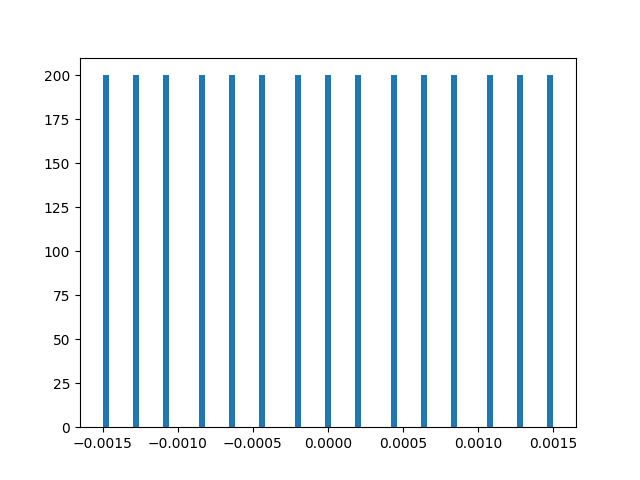

In [8]:
# Histogram plot for the initial delta values
plt.figure()
plt.hist(delta, bins=75)
plt.show()

We can see in the figure above that we have 15 equally spaced values, each with a count of 200, for our 3000 particles.

### Define time-dependent bevior of extraction sextupole

In [9]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 3e-3], y=[0, 0, 1.])

line.vars['sr'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['sr']._expr

(-3.3015954716218534 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [10]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [11]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads='auto')
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

User can provide arbitrary functions executed at every turn (output is automatically logged).

In [12]:
# User-defined quantity to be logged
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

# Vars and user-defined function to be logged
log = xt.Log('sr', intensity=measure_intensity)

### Enable time-dependent vars update for tracking

In [13]:
line.enable_time_dependent_vars = True

### Track!

In [14]:
line.track(particles, num_turns=5000, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

In [15]:
# Record particle coordinates after each turn
rec1 = line.record_last_track

### Plot logged quantities

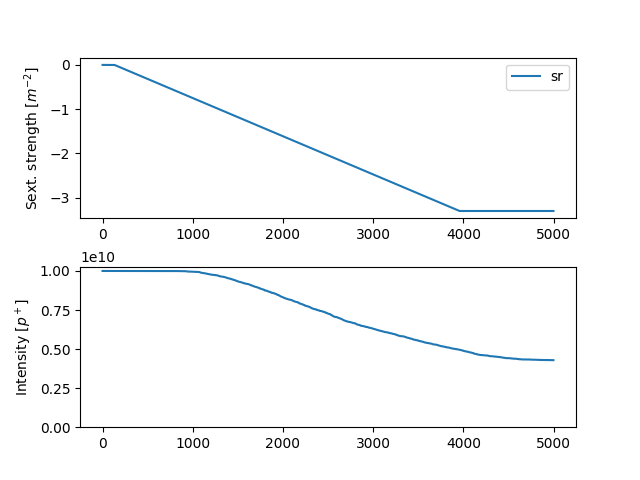

In [16]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(line.log_last_track['sr'], label='sr')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()

ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')

plt.subplots_adjust(hspace=0.3)

In [17]:
# Alive percentage after the tracking only with the resonance sextupole ramp-up
print(f"Percentage of alive particles after sextupole ramp-up:\n{100*(line.log_last_track["intensity"][-1] / beam_intensity)} %")

Percentage of alive particles after sextupole ramp-up:
42.89999999999999 %


### Plot particles after tracking

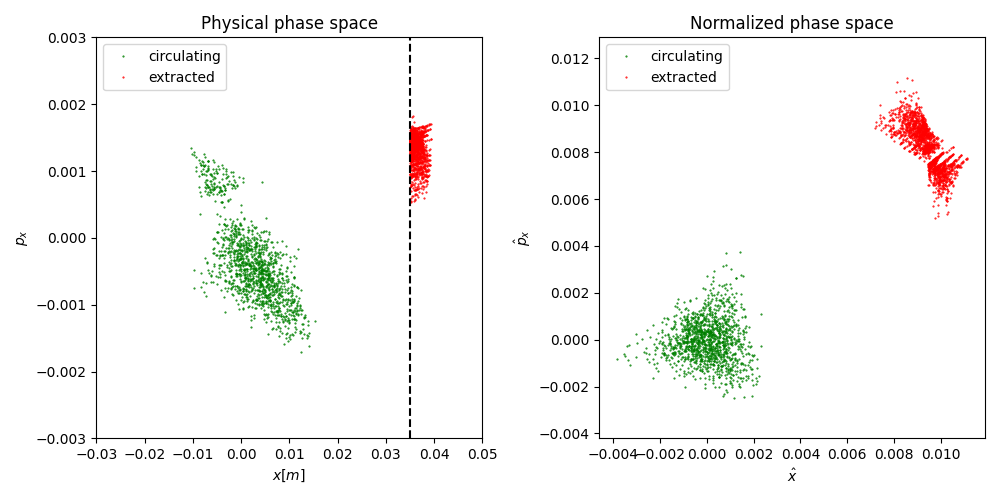

In [18]:
mask_alive = particles.state>0
mask_lost = ~mask_alive

# Get particles normalized coordinates
part_nc = tw.get_normalized_coordinates(particles)

plt.figure(figsize=(10, 5))
ax_geom = plt.subplot(1, 2, 1, title='Physical phase space')
ax_norm = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_geom.plot(particles.x[mask_alive], particles.px[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_geom.plot(particles.x[mask_lost], particles.px[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_geom.set_xlim(-0.03, 0.05); ax_geom.set_ylim(-3e-3, 3e-3)
ax_geom.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_geom.set_xlabel(r'${x} [m]$')
ax_geom.set_ylabel(r'${p}_x$')
ax_geom.legend()

ax_norm.plot(part_nc.x_norm[mask_alive], part_nc.px_norm[mask_alive],
         '.', markersize=1, color='green', label='circulating')
ax_norm.plot(part_nc.x_norm[mask_lost], part_nc.px_norm[mask_lost],
         '.', markersize=1, color='red', label='extracted')
ax_norm.set_aspect('equal', adjustable='datalim')
ax_norm.set_xlabel(r'$\hat{x}$')
ax_norm.set_ylabel(r'$\hat{p}_x$')
ax_norm.legend()

plt.tight_layout()

plt.show()

### Save initial coordinates for lost and alive particles

In [19]:
# Save ids of alive particles
alive_ids=[]
for i in range(0, num_particles):
    if particles.state[i]>0:
        alive_ids.append(particles.particle_id[i])

In [20]:
# Get initial coordinates according to alive particle ids
x_alive=[]
px_alive=[]
y_alive=[]
py_alive=[]
delta_alive=[]
for a in alive_ids:
    x_alive.append(p0.x[p0.particle_id==a].item())
    y_alive.append(p0.y[p0.particle_id==a].item())
    px_alive.append(p0.px[p0.particle_id==a].item())
    py_alive.append(p0.py[p0.particle_id==a].item())
    delta_alive.append(p0.delta[p0.particle_id==a].item())

In [22]:
# Save ids for lost particles
lost_ids=[]
for i in range(0,num_particles):
    if particles.state[i]==0:
        lost_ids.append(particles.particle_id[i])

In [23]:
# Get initial coordinates according to lost particle ids
x_lost=[]
px_lost=[]
y_lost=[]
py_lost=[]
delta_lost=[]
for a in lost_ids:
    x_lost.append(p0.x[p0.particle_id==a].item())
    y_lost.append(p0.y[p0.particle_id==a].item())
    px_lost.append(p0.px[p0.particle_id==a].item())
    py_lost.append(p0.py[p0.particle_id==a].item())
    delta_lost.append(p0.delta[p0.particle_id==a].item())

# Set the index where the alive particles are seperated from the lost ones
split=len(x_alive)+1

Now I build a new particles object, assigning to it the previously calculated coordinates, in a distribution in which the
first values are the initial coordinates of the particles that ended up alive after the previous tracking, and the next values are the initial coordinates of the particles that were lost.

In [24]:
# Build particles
p2 = line.build_particles(x=np.append(x_alive, x_lost),
                          px=np.append(px_alive, px_lost),
                          y=np.append(y_alive, y_lost),
                          py=np.append(py_alive, py_lost),
                          delta=np.append(delta_alive, delta_lost))

In [25]:
# Reset the simulation
line.vars['t_turn_s'] = 0

In [26]:
# Get the normalized coordinates for the second ensemble of particles
nc2 = tw.get_normalized_coordinates(p2)

In [27]:
# Repeat the simulation tracking the second ensemble of particles
line.track(p2, num_turns=5000, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [28]:
# Record particle coordinates after each turn
rec2 = line.record_last_track

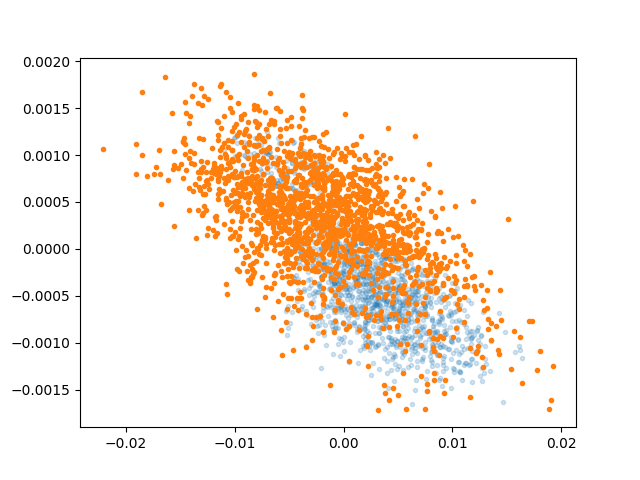

In [29]:
# Plot phase space for all the particles
# (particles that will end as alive in blue and particles that will end as lost in orange)
plt.figure()
plt.plot(rec2.x[:split, 0], rec2.px[:split, 0], '.', alpha=0.2)
plt.plot(rec2.x[split:, 0], rec2.px[split:, 0], '.')

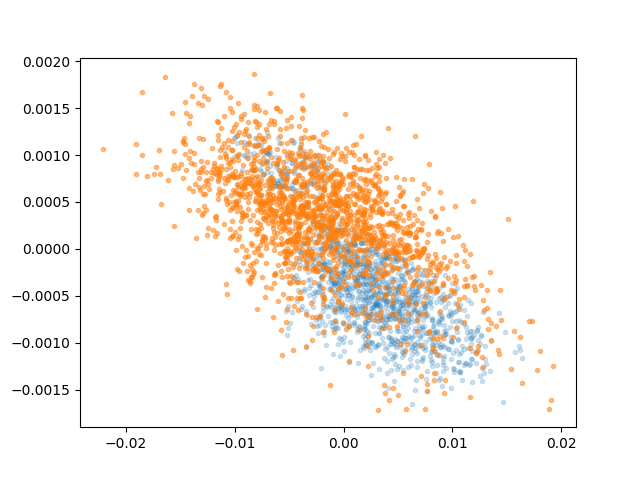

In [30]:
# Checking the initial distribution
plt.figure()
plt.plot(x_alive, px_alive, '.', alpha=0.2)
plt.plot(x_lost, px_lost, '.', alpha=0.5)

The above means that building a second ensemble of particles (p2) is not necessary to split the initial values of the particles that were lost with the particles that remained alive.

### Steinbach Diagram

In [31]:
# Calculate the initial amplitude for the lost and alive particles
amp_alive = np.sqrt(nc2.x_norm[:split]**2 + nc2.px_norm[:split]**2)
amp_lost = np.sqrt(nc2.x_norm[split:]**2 + nc2.px_norm[split:]**2)

Text(0, 0.5, 'Normalised Amplitude')

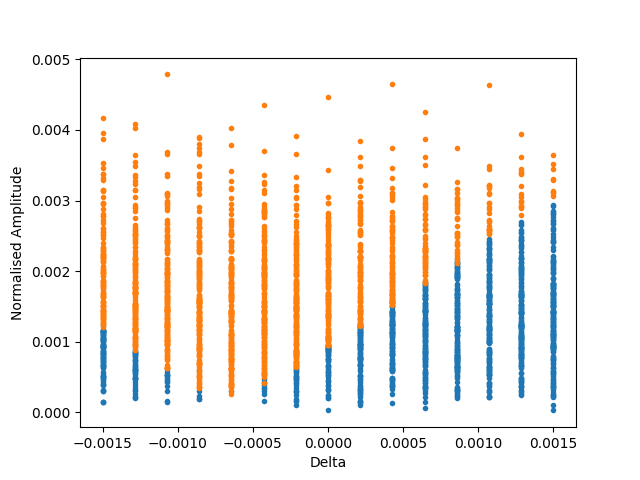

In [32]:
# Plot the calculated normalised amplitudes with respect to delta
plt.figure()
plt.plot(p2.delta[:split], amp_alive, '.')  # Alive particles in blue
plt.plot(p2.delta[split:], amp_lost, '.')   # Lost particles in orange
plt.xlabel("Delta")
plt.ylabel("Normalised Amplitude")

Text(0, 0.5, 'Normalised Amplitude')

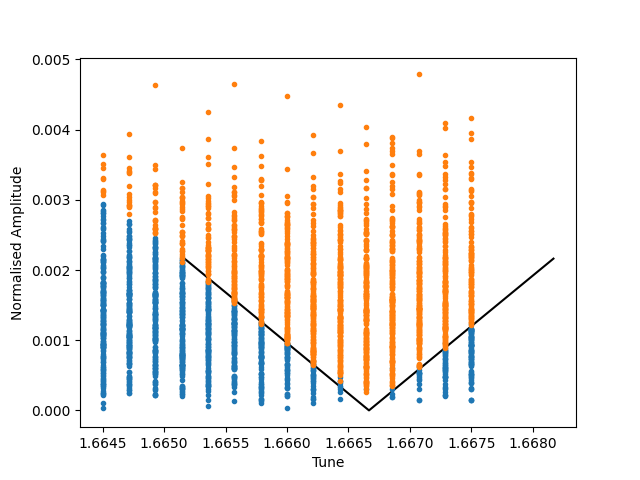

In [33]:
# We calculate the normalized sextupole strength S
norm_sext_strength = 0.5 * (tw['betx', 's8_028a_sxr'])**1.5 * line['s8_028a_sxr'].length * line['sr']

# Now using the normalised resonance sextupole strength, calculate the resonance amplitude.
# We will use it to plot the resonance lines in the Steinbach diagram
res_amplitude = np.sqrt(48*np.pi*np.sqrt(3)) * np.abs(tw.dqx/norm_sext_strength) * np.abs(p2.delta)

# Sort indices based on p2.delta
sort_idx = np.argsort(p2.delta)

# Apply sorting to both arrays
part_tune_sorted = p2.delta[sort_idx] * tw.dqx + 5/3
amplitude_sorted = res_amplitude[sort_idx]

# Plot the Steinbach Diagram
plt.figure()
plt.plot(part_tune_sorted, amplitude_sorted, '-', color='k', markersize=2)
plt.plot(p2.delta[:split] * tw.dqx + tw.qx, amp_alive, '.')
plt.plot(p2.delta[split:] * tw.dqx + tw.qx, amp_lost, '.')
plt.xlabel("Tune")
plt.ylabel("Normalised Amplitude")

### Phase space for selected delta

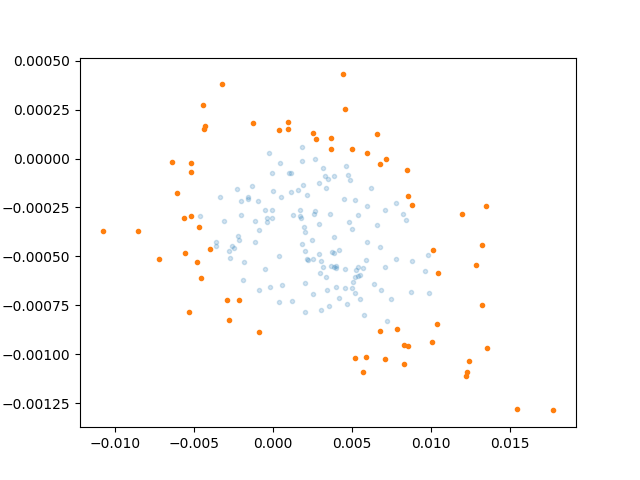

In [34]:
# Choose particles according to delta
err=1e-10           # computational error on line.build_particles
myVal=values[10]    # selected value of delta from initial distribution

# Mask selected delta (for alive and lost)
chosen_alive = (myVal-err<=p2.delta[:split]) & (p2.delta[:split]<=myVal+err)  
chosen_lost = (myVal-err<=p2.delta[split:]) & (p2.delta[split:]<=myVal+err)

# Plot alive and lost selected delta
plt.figure()
plt.plot(rec2.x[:split, 0][chosen_alive], rec2.px[:split, 0][chosen_alive], '.', alpha=0.2)
plt.plot(rec2.x[split:, 0][chosen_lost], rec2.px[split:, 0][chosen_lost], '.')